By Soham Govande and Aaryan Shah

**Citations**: When learning how to use scikit-learn, keras, OpenCV, and other libraries, we used the following websites as sources of information:

1) https://www.geeksforgeeks.org/implement-photoshop-high-pass-filter-hpf-using-opencv-in-python/
2) https://docs.opencv.org/4.x/dd/d6a/tutorial_js_filtering.html
3) https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=EXPLORE%20COURSE-,Layers%20in%20a%20Convolutional%20Neural%20Network,-A%20convolution%20neural
4) https://www.kaggle.com/code/kanishk26/sipkamed-dataset
5) https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c?gi=85731d1e6829

[[  0 825]
 [  1 793]
 [  2 813]
 [  3 787]
 [  4 831]]


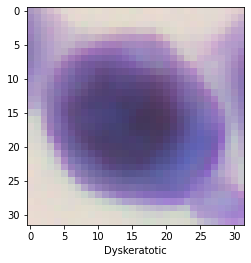

In [8]:
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
import tensorflow
import cv2
from keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import accuracy_score

imgdata = []
labels = []
compressed_img_size = 32
celltypes = ['im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = ["../input/cervical-cancer-largest-dataset-sipakmed/" + celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]

# Low pass filter
LOW_PASS_FILTER = False
# High pass filter
HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1
    # Iterate over each cell's individual image
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            if LOW_PASS_FILTER:
                img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            elif HIGH_PASS_FILTER:
                img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            imgdata.append(img)

labels = np.array(labels)
imgdata = np.array(imgdata)

# Shuffle/randomize order
random_order = np.arange(imgdata.shape[0])
np.random.shuffle(random_order)
labels = labels[random_order]
imgdata = imgdata[random_order]

# Get # of each cell type
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

# Used for generating figures (displaying cell images)
def disp_img(i):
    plt.imshow(imgdata[i])
    plt.xlabel(celltypes[labels[i]][len('im_'):])
    
for i in range(0, len(labels)):
    # Replace this with 0, 1, 2, 3, or 4 depending on the type of figure being generated
    if labels[i] == 2:
        disp_img(i)
        break
        
# Initialize neural networks
model_efficientnet = EfficientNetB7(weights=None, include_top = False)
features_efficientnet = model_efficientnet.predict(imgdata, batch_size=32)

cur = features_efficientnet
extracted_features = []
zipped_data = zip(cur, labels)
for cur, label in zipped_data:
    cur = np.append(cur.reshape(cur.shape[0] * cur.shape[1] * cur.shape[2]), label)
    extracted_features.append(cur)
extracted_features = np.array(extracted_features)

# Use min-max scaling to normalize the data
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# PCA
# This step is ONLY done for 1/2 of the pipelines
pca = PCA(n_components = 0.95) # represent 95% of the variation through principal components
pca.fit(scaled_X)
pca_x = pca.transform(scaled_X)

# For 1/2 of the pipelines, use pca_x as the first variable. For the other 1/2 of pipelines, without PCA, use scaled_X as the first variable.
X_train, X_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 50)

# Neural network for classification
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], 1)),
    Dense(256, activation='relu'),
    Dropout(rate=0.8),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

In [9]:
# Train the neural network
nn = model.fit(X_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
102/102 [==============================] - 1s 2ms/step - loss: 1.4985 - accuracy: 0.4162
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 1.1015 - accuracy: 0.5783
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.9274 - accuracy: 0.6505
Epoch 4/100
102/102 [==============================] - 0s 2ms/step - loss: 0.8544 - accuracy: 0.6774
Epoch 5/100
102/102 [==============================] - 0s 2ms/step - loss: 0.8071 - accuracy: 0.7021
Epoch 6/100
102/102 [==============================] - 0s 2ms/step - loss: 0.7735 - accuracy: 0.7209
Epoch 7/100
102/102 [==============================] - 0s 2ms/step - loss: 0.7375 - accuracy: 0.7268
Epoch 8/100
102/102 [==============================] - 0s 2ms/step - loss: 0.7103 - accuracy: 0.7376
Epoch 9/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.7487
Epoch 10/100
102/102 [==============================] - 0s 2ms/step - loss: 0.6848 - accura

In [10]:
# Predict on the test set and determine the accuracy
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

Accuracy is: 86.17283950617283%


In [11]:
import tensorflow as tf
tf.math.confusion_matrix(
    y_test,
    y_pred
)

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[133,   9,   6,   2,  15],
       [  6, 126,   2,   2,  14],
       [ 10,   0, 155,   0,   4],
       [  2,   6,   6, 148,   5],
       [ 11,   8,   1,   3, 136]], dtype=int32)>

In [12]:
y_test[6]

3.0